In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(color_codes=True)

## Import dataset

In [2]:
df = pd.read_csv('1979-2021(1).csv', index_col='Date', parse_dates=['Date'])
df.head()

,United States(USD)
Date,
1979-01-31,233.7
1979-02-28,251.3
1979-03-30,240.1
1979-04-30,245.3
1979-05-31,274.6


<AxesSubplot:xlabel='Date'>

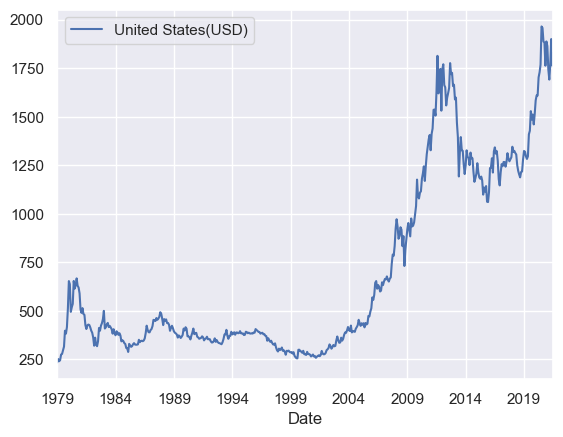

In [3]:
df.plot()

## Normalize the Data and Train Test Split 

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [5]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [6]:
ts_train, ts_test = train_test_split(df_scaled, test_size=0.2, shuffle=False, random_state=42)
ts_train.shape, ts_test.shape

((408, 1), (103, 1))

## Create sequences for LSTM

In [7]:
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(x), np.array(y)

sequence_length = 10

X_train, y_train = create_sequences(ts_train, sequence_length)
X_test, y_test = create_sequences(ts_test, sequence_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 10, 1), (93, 10, 1), (398,), (93,))

## Build and Train the LSTM model

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [10]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history_lstm = model.fit(X_train, y_train, epochs=10, batch_size=64)



Epoch 1/10

7/7 [==============================] - 3s 10ms/step - loss: 0.0328
Epoch 2/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 3/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 4/10
7/7 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 5/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 6/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 8/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 9/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 10/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0014


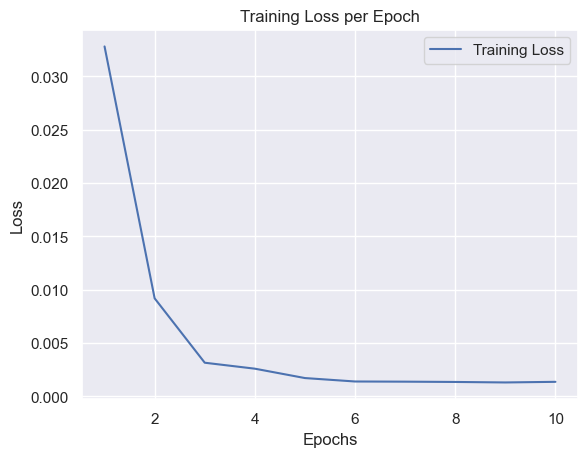

In [11]:
loss_values = history_lstm.history['loss']

plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize the Actual and Predicted Close Price

In [12]:
var = 'United States(USD)'

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

3/3 [==============================] - 1s 5ms/step


In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

In [14]:
def evaluation(y_test, y_pred):
    print('Coeficient of determination: %.2f'% r2_score(y_test, y_pred))
    print('Mean squared error         : %.2f'% mean_squared_error(y_test, y_pred))
    print('Root mean squared error    : %.2f'% np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Explained variance score   : %.2f'% explained_variance_score(y_test, y_pred))
    print('Mean absolute error        : %.2f'% mean_absolute_error(y_test, y_pred))

In [15]:
evaluation(df[-len(predictions):][var], predictions)

Coeficient of determination: 0.77
Mean squared error         : 12240.28
Root mean squared error    : 110.64
Explained variance score   : 0.79
Mean absolute error        : 91.42


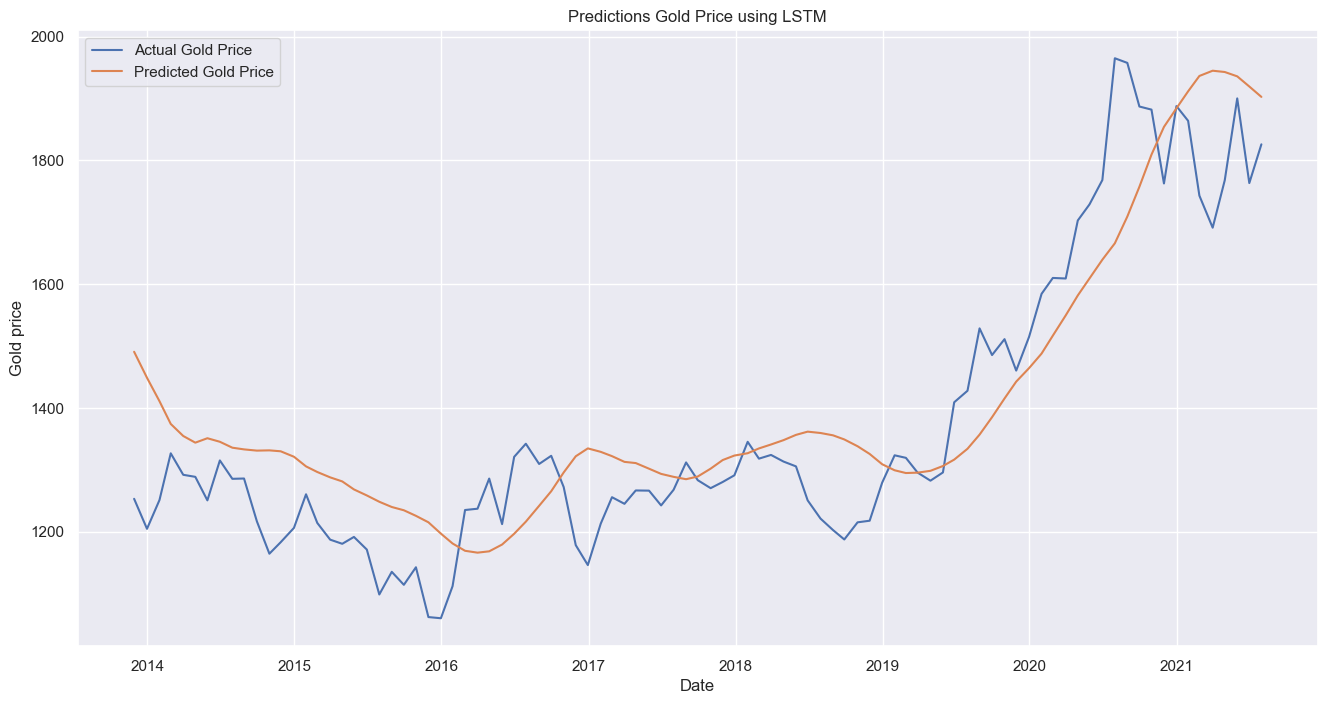

In [16]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(predictions):], df[-len(predictions):][var], label='Actual Gold Price')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Gold Price')
plt.title('Predictions Gold Price using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold price')
plt.legend()
plt.show()

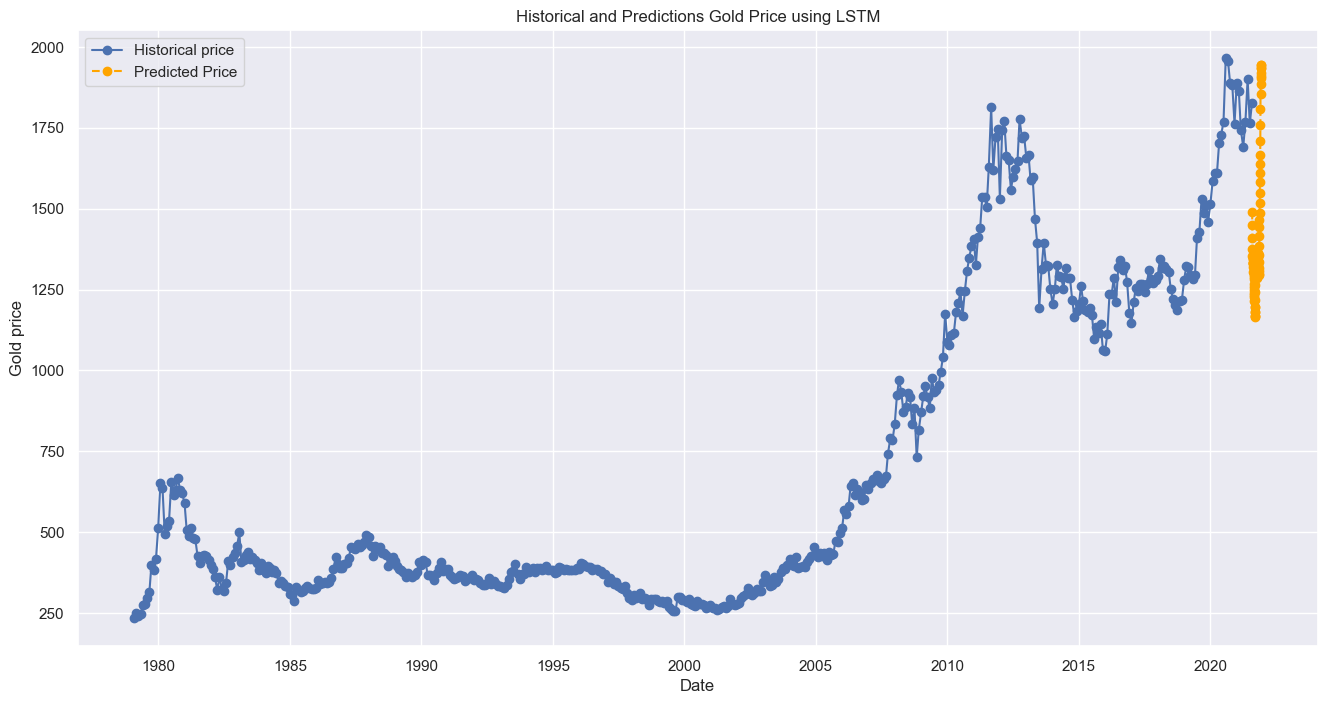

In [17]:
plt.figure(figsize=(16,8))
plt.plot(df.index, df[var], label='Historical price', marker='o', linestyle='-', color='b')

pred_dates = pd.date_range(start=df.index[-1], periods=len(predictions)+1, freq='B')[1:]
plt.plot(pred_dates, predictions, label='Predicted Price', linestyle='dashed', color='orange',marker='o')

plt.title('Historical and Predictions Gold Price using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold price')
plt.legend()
plt.show()

## Build and Train the GRU model

In [18]:
from keras.layers import GRU

In [19]:
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(50, return_sequences=False))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
7/7 [==============================] - 3s 10ms/step - loss: 0.0354
Epoch 2/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0109
Epoch 3/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 4/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 5/10
7/7 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 6/10
7/7 [==============================] - 0s 8ms/step - loss: 9.9534e-04
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 8.2190e-04
Epoch 8/10
7/7 [==============================] - 0s 8ms/step - loss: 8.1223e-04
Epoch 9/10
7/7 [==============================] - 0s 8ms/step - loss: 7.2814e-04
Epoch 10/10
7/7 [==============================] - 0s 8ms/step - loss: 7.1725e-04


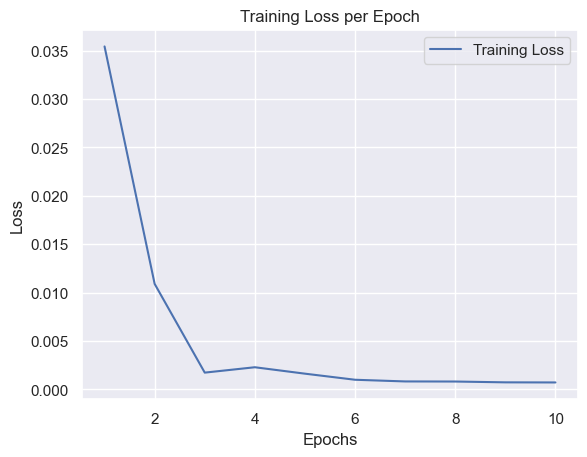

In [20]:
loss_values = history_gru.history['loss']

plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize the Actual and Predicted Close Price

In [21]:
predictions = model_gru.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

3/3 [==============================] - 1s 11ms/step


In [22]:
evaluation(df[-len(predictions):][var], predictions)

Coeficient of determination: 0.85
Mean squared error         : 8190.01
Root mean squared error    : 90.50
Explained variance score   : 0.89
Mean absolute error        : 73.81


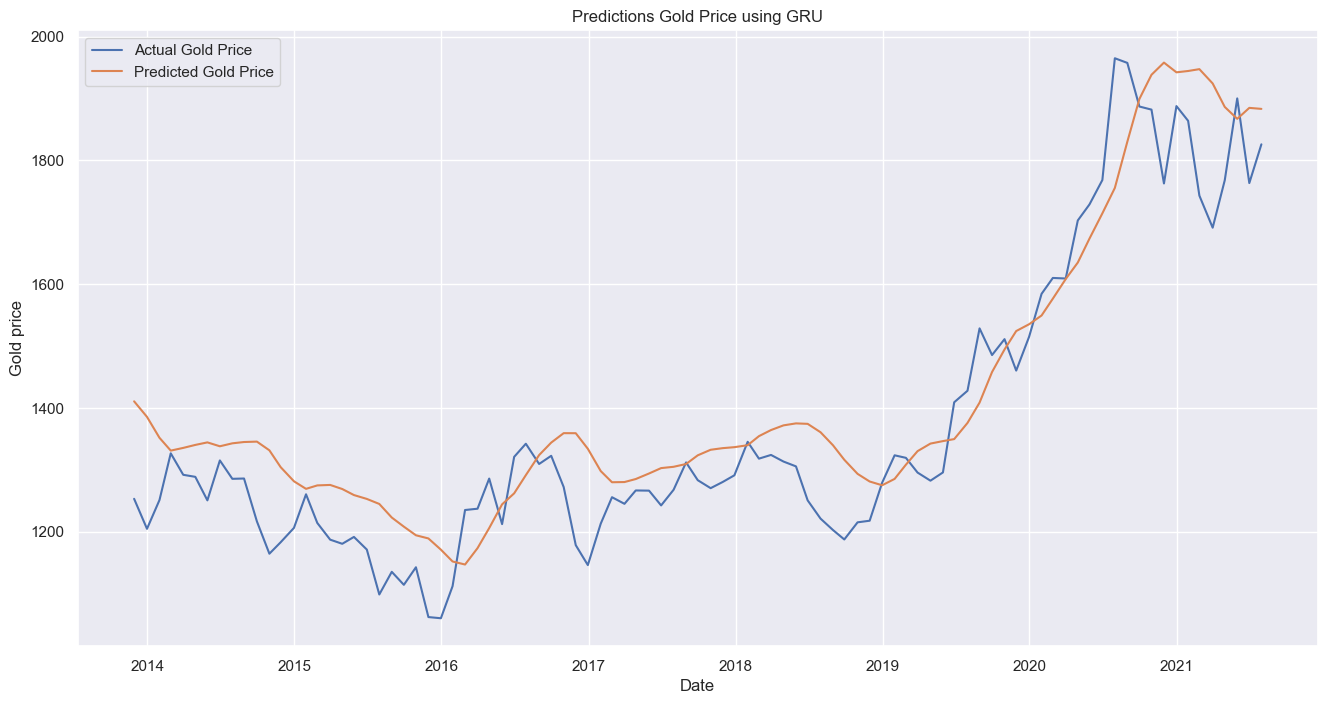

In [23]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(predictions):], df[-len(predictions):][var], label='Actual Gold Price')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Gold Price')
plt.title('Predictions Gold Price using GRU')
plt.xlabel('Date')
plt.ylabel('Gold price')
plt.legend()
plt.show()

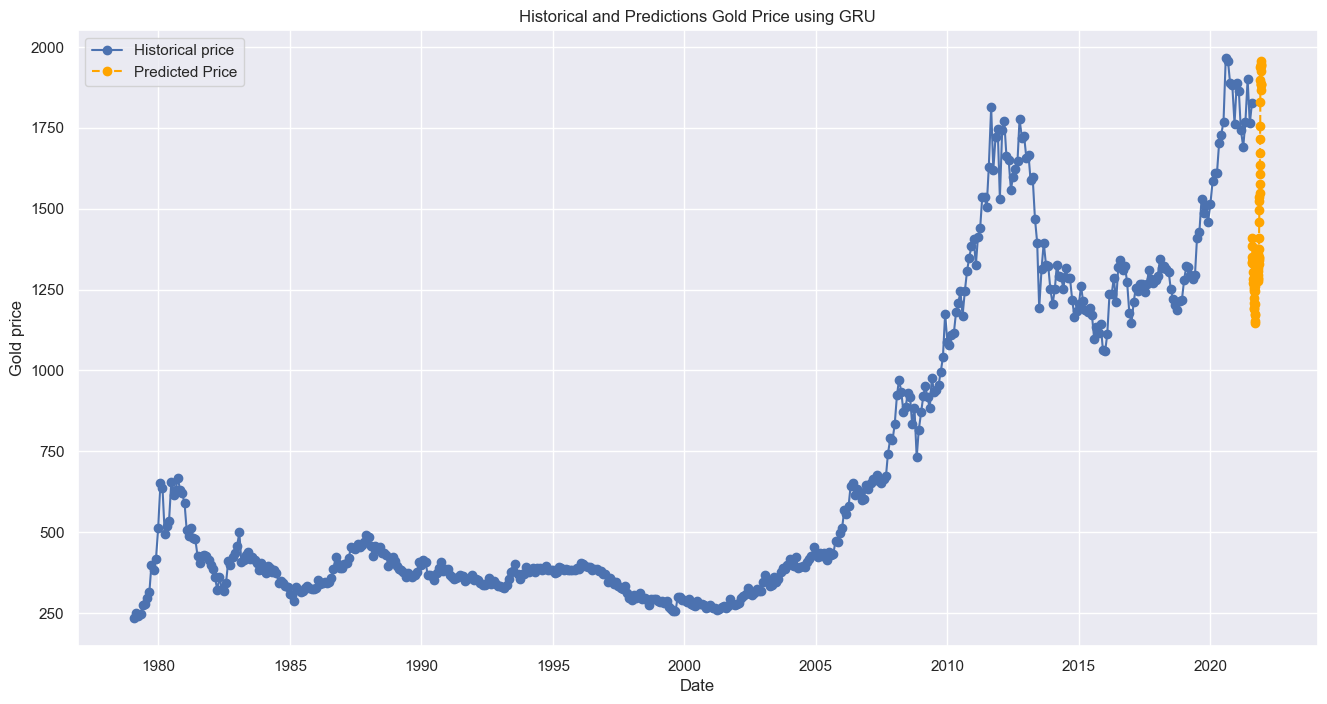

In [24]:
plt.figure(figsize=(16,8))
plt.plot(df.index, df[var], label='Historical price', marker='o', linestyle='-', color='b')

pred_dates = pd.date_range(start=df.index[-1], periods=len(predictions)+1, freq='B')[1:]
plt.plot(pred_dates, predictions, label='Predicted Price', linestyle='dashed', color='orange',marker='o')

plt.title('Historical and Predictions Gold Price using GRU')
plt.xlabel('Date')
plt.ylabel('Gold price')
plt.legend()
plt.show()

## Build and Train the GRU model

In [25]:
from keras.layers import SimpleRNN

In [26]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_rnn.add(SimpleRNN(50, return_sequences=False))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

history_rnn = model_rnn.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
7/7 [==============================] - 2s 4ms/step - loss: 0.0268
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 6.4092e-04
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 6.5340e-04
Epoch 9/10
7/7 [==============================] - 0s 5ms/step - loss: 6.0721e-04
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 7.6168e-04


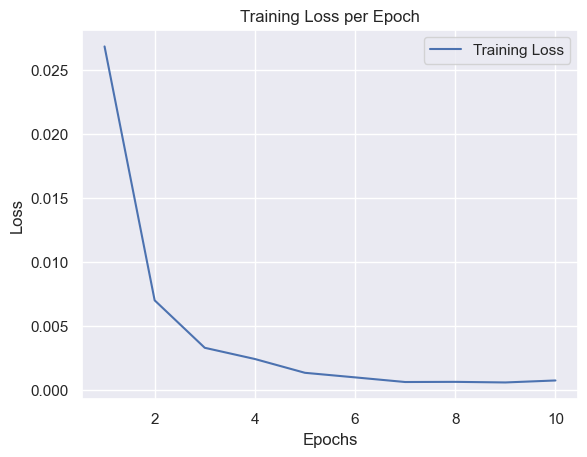

In [27]:
loss_values = history_rnn.history['loss']

plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize the Actual and Predicted Close Price

In [28]:
var = 'United States(USD)'

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

3/3 [==============================] - 0s 10ms/step


In [29]:
evaluation(df[-len(predictions):][var], predictions)

Coeficient of determination: 0.88
Mean squared error         : 6415.73
Root mean squared error    : 80.10
Explained variance score   : 0.90
Mean absolute error        : 66.25


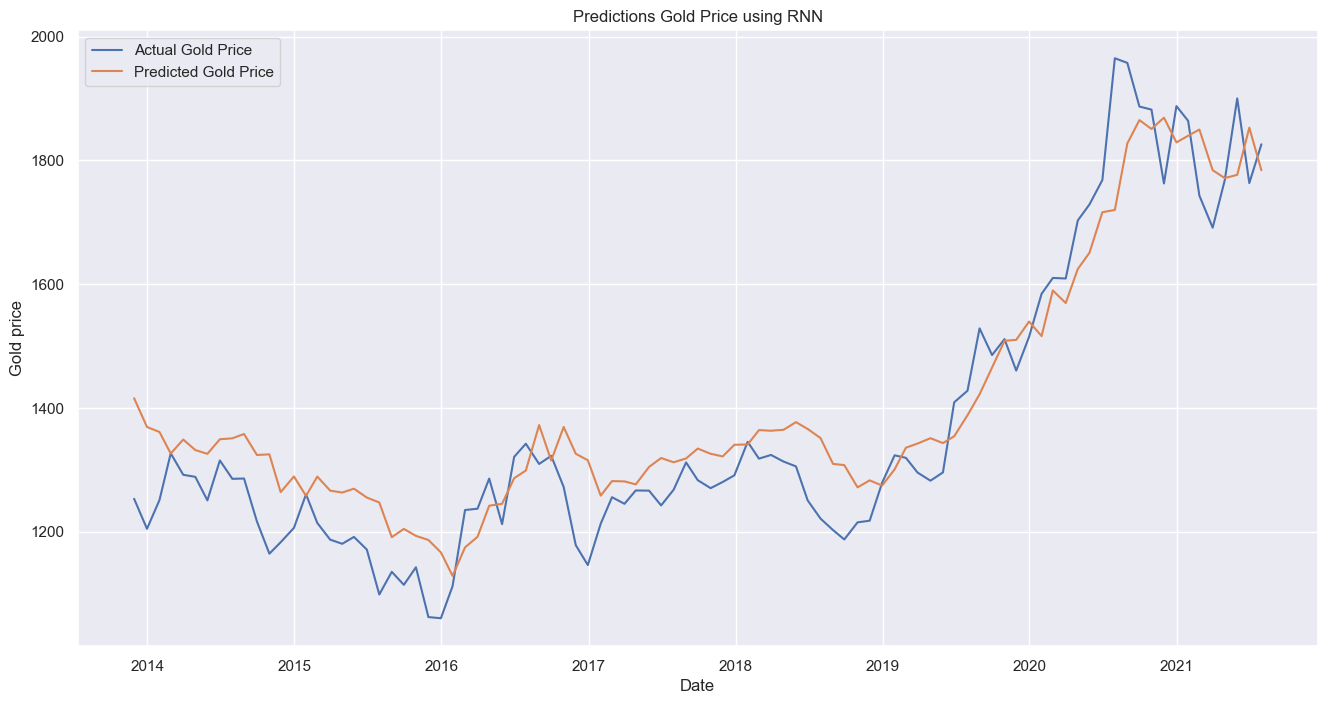

In [30]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(predictions):], df[-len(predictions):][var], label='Actual Gold Price')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Gold Price')
plt.title('Predictions Gold Price using RNN')
plt.xlabel('Date')
plt.ylabel('Gold price')
plt.legend()
plt.show()

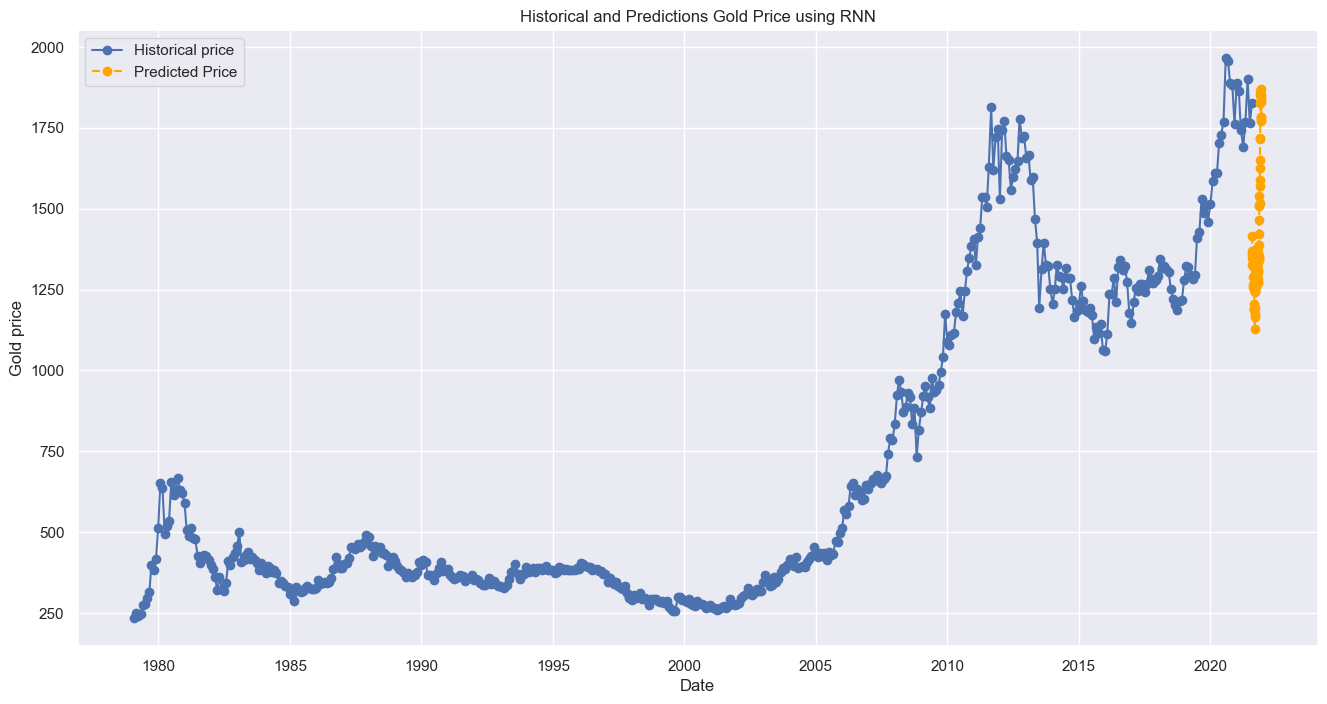

In [31]:
plt.figure(figsize=(16,8))
plt.plot(df.index, df[var], label='Historical price', marker='o', linestyle='-', color='b')

pred_dates = pd.date_range(start=df.index[-1], periods=len(predictions)+1, freq='B')[1:]
plt.plot(pred_dates, predictions, label='Predicted Price', linestyle='dashed', color='orange',marker='o')

plt.title('Historical and Predictions Gold Price using RNN')
plt.xlabel('Date')
plt.ylabel('Gold price')
plt.legend()
plt.show()